In [1]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import nibabel as nib
import scipy
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import copy
import glob
sys.path.insert(1, '/export03/data/opt/Hippo_Spin_Testing')
from hippo_spin_testing import spin_test
sys.path.insert(1, '/data/mica1/01_programs/micapipe-v0.2.0/functions')
from build_mpc import build_mpc
from brainspace.gradient import GradientMaps
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [47]:
files = [
 '../maps/HippoMaps-initializationMaps/Dataset-BigBrain/histology-Merker_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AxerPLI/histology-PLI-transmittance_average-1_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Bieloschowsky_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Blockface_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Parvalbumin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Thionin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Calbindin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Calretinin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
    
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-qR1_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-qR2star_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-ProtonDensity_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-qT1_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-FA_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-ADC_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-T2star_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-MTR_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',

 '../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-IntTS_average-99_hemi-L_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-ReHo_average-99_hemi-L_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-avgFCneocort_average-80_hemi-L_den-2mm_label-hipp.shape.gii',

 '../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-delta_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-theta_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-alpha_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-beta_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-gamma_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',

 '../maps/HippoMaps-initializationMaps/Dataset-Mixed/histology-curvature_average-7_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-curvature_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-Mixed/histology-gyrification_average-7_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-gyrification_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-Mixed/histology-thickness_average-7_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-thickness_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 ]

In [48]:
# organize into sensible blocks of the same modality

blocks_len = [8,8,3,5,6]
blocks = np.concatenate(([0],np.cumsum(blocks_len)))
colors = np.hstack((np.ones((blocks_len[0])),np.ones((blocks_len[1]))+1,np.ones((blocks_len[2]))+2,np.ones((blocks_len[3]))+3,np.ones((blocks_len[4]))+4))

In [50]:
# load all data
features = []
cdata = np.ones((7262,len(files)))
for f in range(len(files)):
    features.append(files[f].split('/')[-1].split('_')[0])
    den = files[f].split('/')[-1].split('_')[3][4:]
    cdata[:,f],_,_ = utils.density_interp(den,'0p5mm',nib.load(files[f]).darrays[0].data, label='hipp')

In [5]:
# check for significant correlation (spin test) (slow!)

feat_corr_p = np.ones((len(features),len(features)))
for i in range(len(features)):
    for j in range(i+1,len(features)):
        _,_,feat_corr_p[i,j],_ = spin_test.spin_test(cdata[:,i],cdata[:,j], 10000, space='orig')

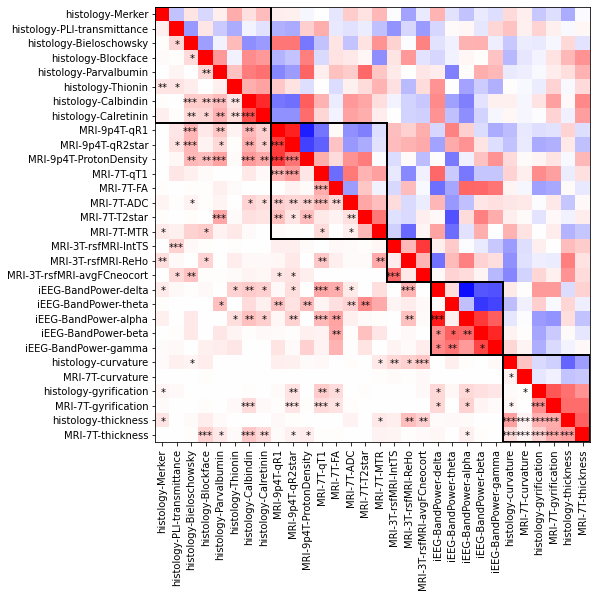

In [6]:
# plot correlation between features

feat_corr = np.corrcoef(cdata.T)

# bottom left will show Rsquared
iloc = np.tril_indices(len(feat_corr))
feat_corr[iloc] = feat_corr[iloc]**2

# plot and label
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(features)),labels=features);
plt.xticks(ticks=range(len(features)),labels=features, rotation=90);

# box around same modality
for i in range(len(blocks)-1):
    w = blocks[i+1]-blocks[i]
    rect = Rectangle((blocks[i]-.5,blocks[i]-.5),w,w, linewidth=2, edgecolor='k', facecolor='none')
    ax.add_patch(rect)

# annotate significant correlations
for i in range(len(features)):
    for j in range(i+1,len(features)):
        if feat_corr_p[i,j] < 0.001:
            plt.annotate('***', (i-.6,j+.3));
        elif feat_corr_p[i,j] < 0.01:
            plt.annotate('**', (i-.3,j+.3));
        elif feat_corr_p[i,j] < 0.05:
            plt.annotate('*', (i-.15,j+.3));

cdata all NaN


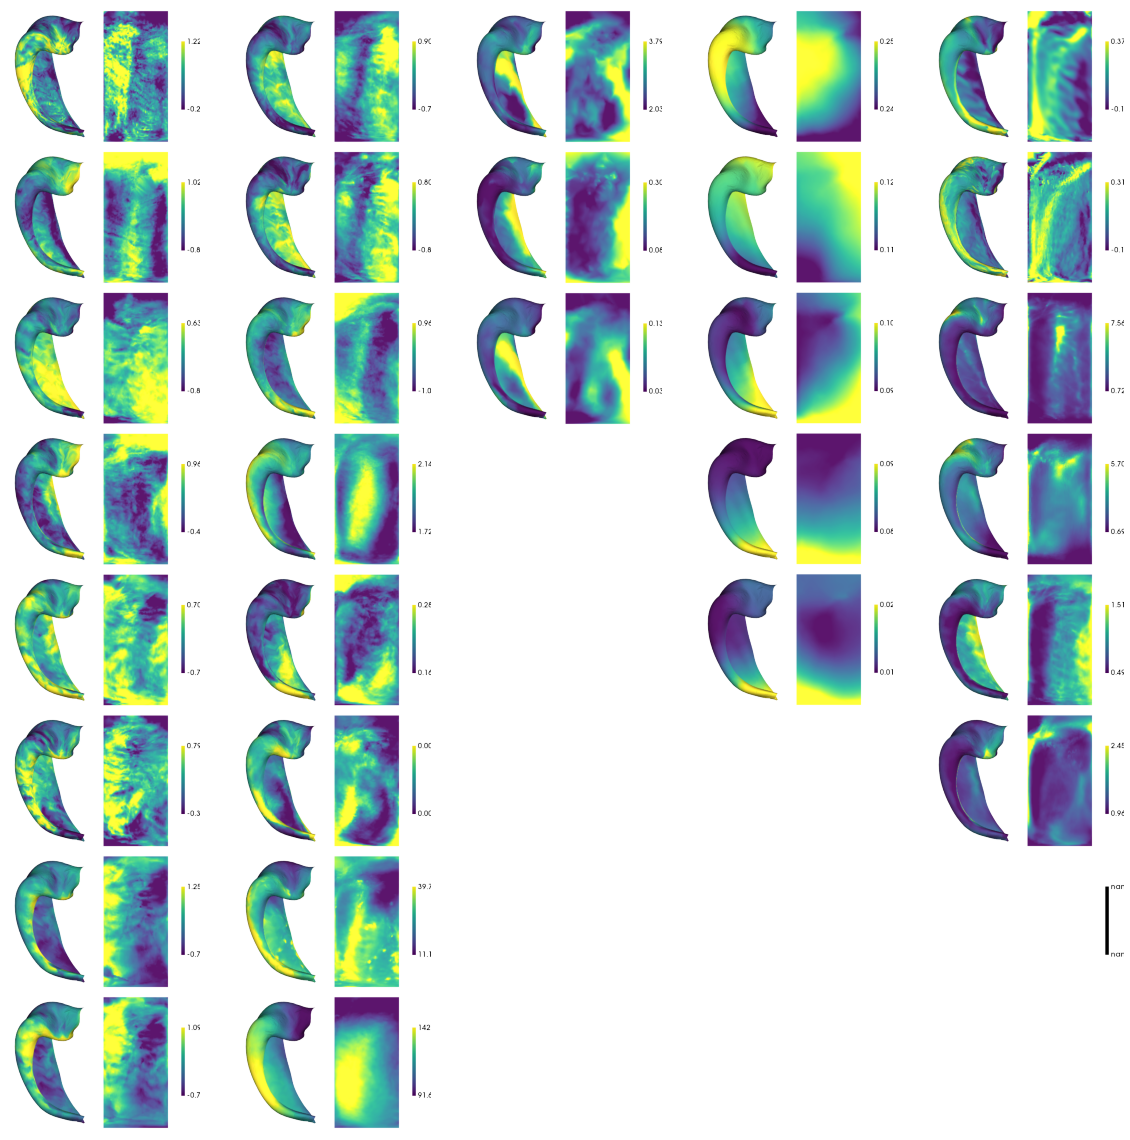

In [52]:
# currently there is a bug where 9 plots are not allowed, but 10 are, so we add an extra empty plot
cdata = np.concatenate((cdata,np.ones((cdata.shape[0],1))*np.nan),axis=1)
blocks[-1] = blocks[-1]+1

# plot all feature maps in the same plot
fig, ax = plt.subplots(1,5, figsize=(20,50))
for b in range(5):
    plotting.surfplot_canonical_foldunfold(cdata[:,blocks[b]:blocks[b+1]], color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True, screenshot=True, filename='tmp.png')
    f = plt.imread('tmp.png')
    ax[b].imshow(f)
    ax[b].set_axis_off()
    ax[b].set_anchor("NW")

cdata = cdata[:,:-1]
!rm tmp.png

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


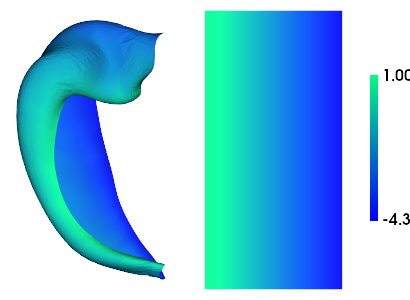

In [8]:
subfields = nib.load('/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0_supersession/hippunfold/sub-PNC002/surf/sub-PNC002_hemi-L_space-T1w_den-0p5mm_label-hipp_atlas-histologyReference2023_subfields.label.gii').darrays[0].data
AP,_,_ = utils.density_interp('unfoldiso','0p5mm',repmat(np.linspace(0,1,254),126,1).flatten(), label='hipp')
PD,_,_ = utils.density_interp('unfoldiso','0p5mm',repmat(np.linspace(0,1,126),254,1).T.flatten(), label='hipp')
plotting.surfplot_canonical_foldunfold(PD, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', cmap='winter', tighten_cwindow=False, embed_nb=True)

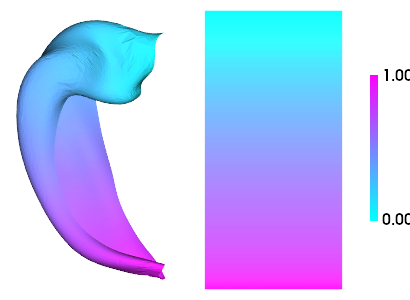

In [9]:
plotting.surfplot_canonical_foldunfold(AP, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', cmap='cool', tighten_cwindow=False, embed_nb=True)

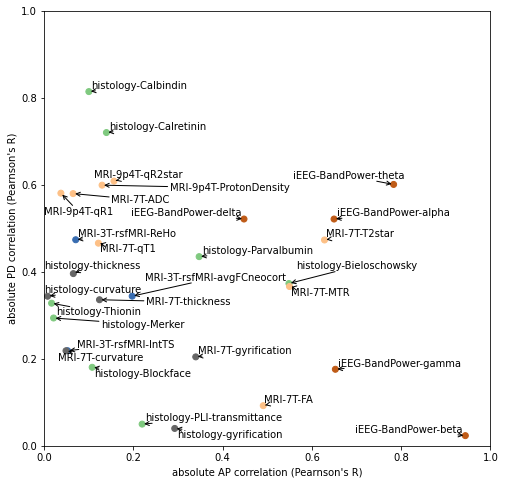

In [51]:
from adjustText import adjust_text

axiscorr = np.abs(np.corrcoef(np.concatenate((cdata,AP.reshape(7262,1),PD.reshape(7262,1)),axis=1).T)[-2:,:-2])

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(axiscorr[0],axiscorr[1],c=colors,cmap='Accent')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("absolute AP correlation (Pearnson's R)")
plt.ylabel("absolute PD correlation (Pearnson's R)")
texts = []
for f,feature in enumerate(features):
    texts.append(ax.annotate(feature, (axiscorr[0,f], axiscorr[1,f])))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'));

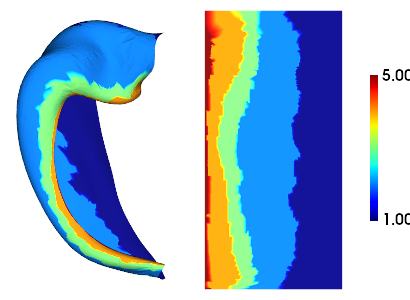

In [11]:
plotting.surfplot_canonical_foldunfold(subfields, color_bar=('right'), hemis=['L'], labels=['hipp'], cmap='jet', unfoldAPrescale=True, share='row', tighten_cwindow=False, embed_nb=True)

In [12]:
from itertools import product
list(product(np.arange(3), repeat=3))

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [13]:
perms = list(product([1,2,3,4,5],repeat=5))
subfields_permuted = np.ones((len(subfields),len(perms)))*np.nan
for p in range(len(perms)):
    newsf = np.ones((len(subfields)))*np.nan
    for s in range(5):
        newsf[subfields==s+1] = perms[p][s]
    subfields_permuted[:,p] = newsf

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


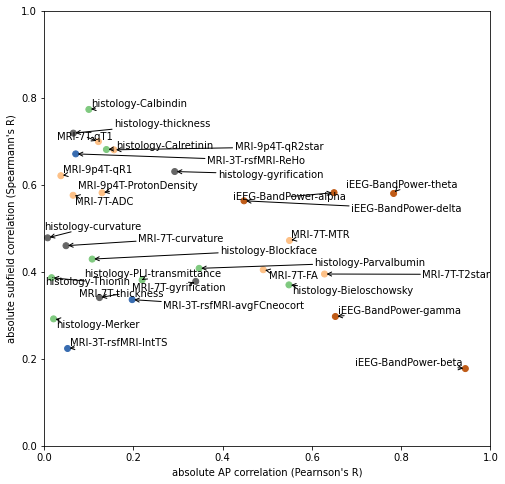

In [52]:
from scipy.stats import spearmanr
subfieldscorr = np.abs(spearmanr(np.concatenate((cdata,subfields_permuted),axis=1))[0][len(features):,:len(features)])
subfieldsmaxcorr = np.nanmax(subfieldscorr,axis=0)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(axiscorr[0],subfieldsmaxcorr,c=colors,cmap='Accent')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("absolute subfield correlation (Spearmann's R)")
plt.xlabel("absolute AP correlation (Pearnson's R)")
texts = []
for f,feature in enumerate(features):
    texts.append(ax.annotate(feature, (axiscorr[0,f],subfieldsmaxcorr[f])))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'));

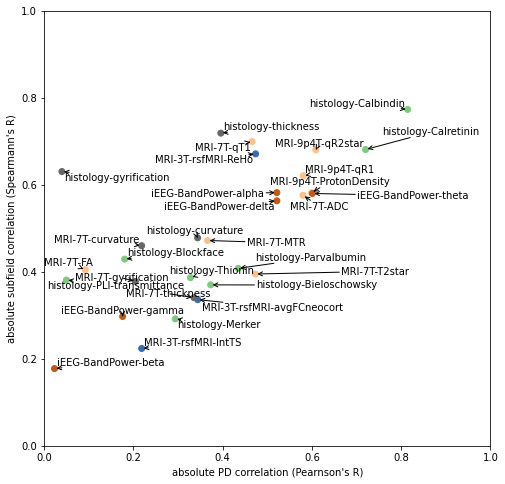

In [56]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(axiscorr[1],subfieldsmaxcorr,c=colors,cmap='Accent')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("absolute subfield correlation (Spearmann's R)")
plt.xlabel("absolute PD correlation (Pearnson's R)")
texts = []
for f,feature in enumerate(features):
    texts.append(ax.annotate(feature, (axiscorr[1,f],subfieldsmaxcorr[f])))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'));

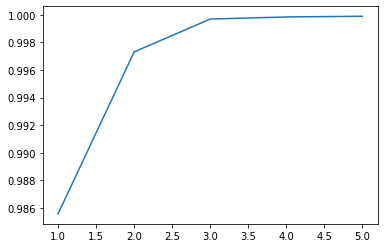

In [72]:
pca = PCA(whiten=True)
principalComponents = pca.fit_transform(cdata)
plt.plot(np.arange(5)+1, np.cumsum(pca.explained_variance_ratio_[:5]))

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


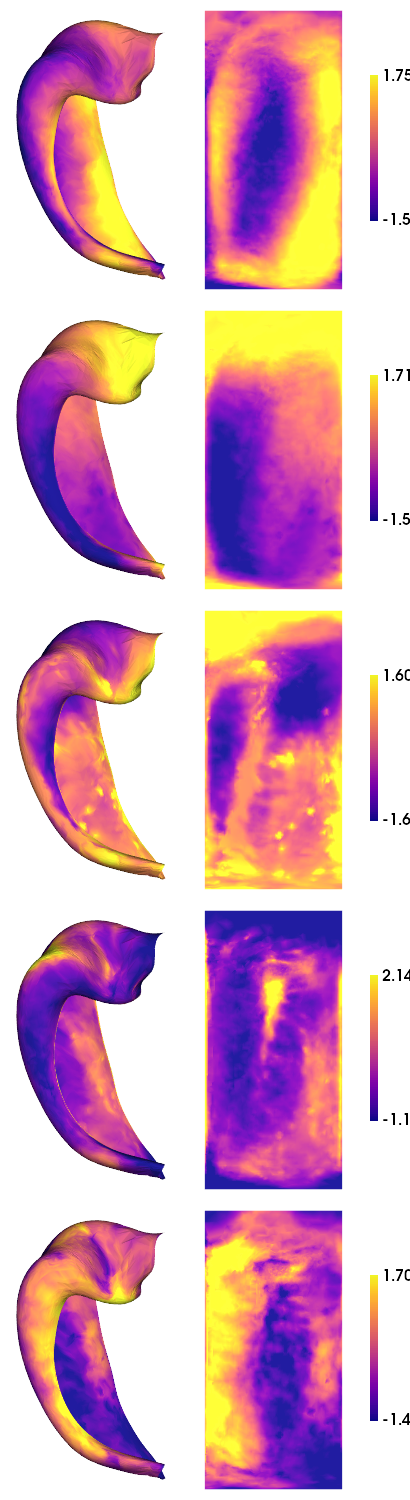

In [75]:
plotting.surfplot_canonical_foldunfold(principalComponents[:,:5], labels=['hipp'], hemis=['L'], unfoldAPrescale=True, cmap='plasma', color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

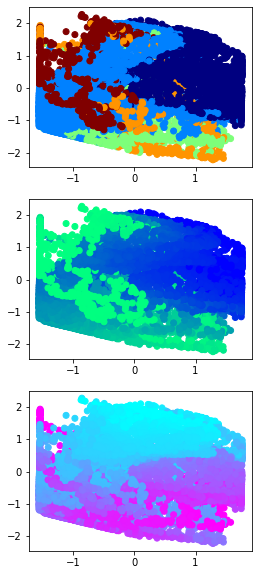

In [73]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(4, 10))
ax[0].scatter(principalComponents[:,0], principalComponents[:,1], c=subfields, cmap='jet')
#ax[0].set_aspect('equal', 'box')
ax[1].scatter(principalComponents[:,0], principalComponents[:,1], c=PD, cmap='winter')
#ax[1].set_aspect('equal', 'box')
ax[2].scatter(principalComponents[:,0], principalComponents[:,1], c=AP, cmap='cool')
#ax[2].set_aspect('equal', 'box')

In [56]:
a = np.array([[1,2,3],[4,5,6]])
a.shape

(2, 3)

In [57]:
scipy.stats.zscore(a,axis=1)

array([[-1.22474487,  0.        ,  1.22474487],
       [-1.22474487,  0.        ,  1.22474487]])

In [58]:
cdata.shape

(7262, 30)

In [118]:
# gradient decomposition
ngrads=5
mmgm = GradientMaps(n_components=ngrads, kernel='pearson', random_state=0)
mmgm.fit(scipy.stats.zscore(cdata), sparsity=0.1)

GradientMaps(kernel='pearson', n_components=5, random_state=0)

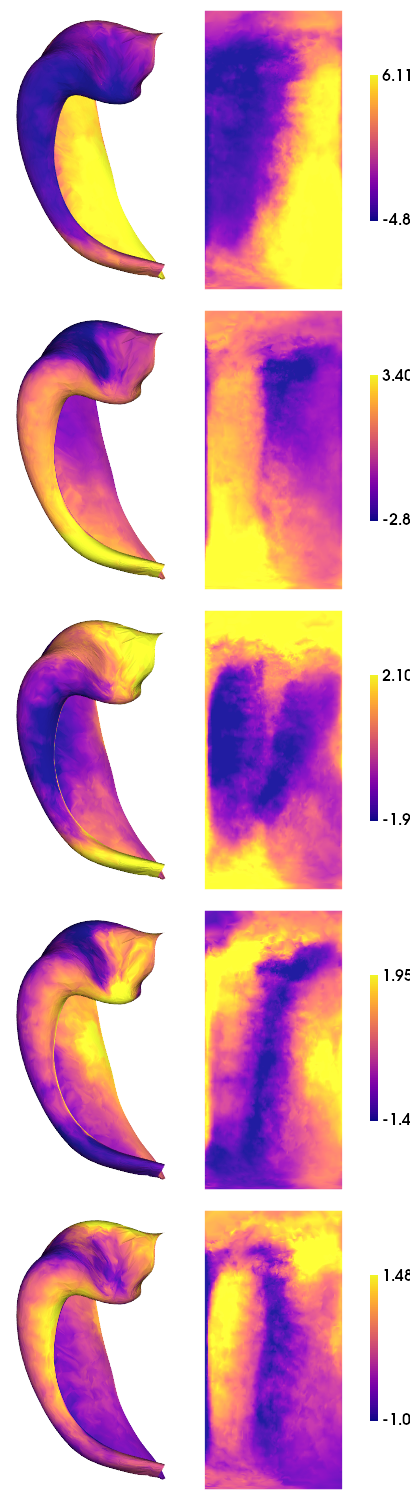

In [119]:
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], unfoldAPrescale=True, cmap='plasma', color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

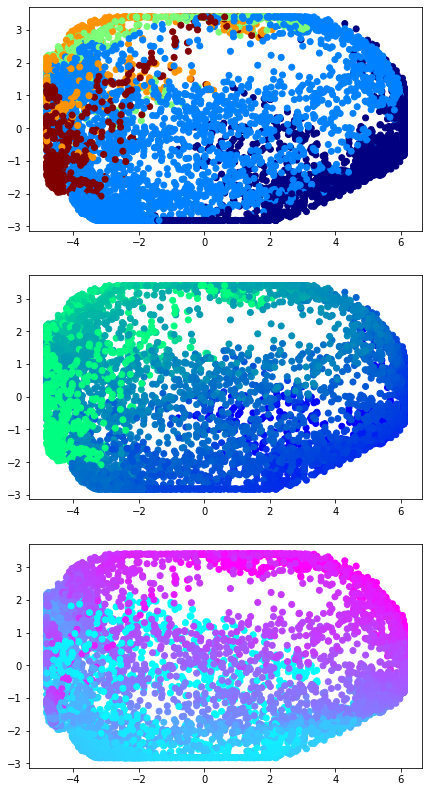

In [120]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 14))
ax[0].scatter(mmgm.gradients_[:,0], mmgm.gradients_[:,1], c=subfields, cmap='jet')
ax[0].set_aspect('equal', 'box')
ax[1].scatter(mmgm.gradients_[:,0], mmgm.gradients_[:,1], c=PD, cmap='winter')
ax[1].set_aspect('equal', 'box')
ax[2].scatter(mmgm.gradients_[:,0], mmgm.gradients_[:,1], c=AP, cmap='cool')
ax[2].set_aspect('equal', 'box')

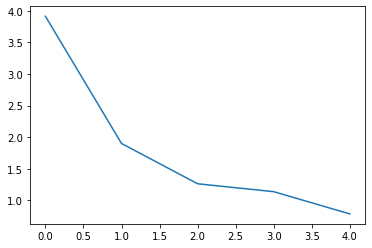

In [123]:
plt.plot(mmgm.lambdas_)

# shelf

In [122]:
# save everything
import shelve
filename='../checkpoints/DimReduct.out'
my_shelf = shelve.open(filename,'n') # 'n' for new
for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except:
        # __builtins__, my_shelf, and imported modules can not be shelved.
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: copy
ERROR shelving: exit
ERROR shelving: get_ipython
ERROR shelving: glob
ERROR shelving: my_shelf
ERROR shelving: nib
ERROR shelving: np
ERROR shelving: plotting
ERROR shelving: plt
ERROR shelving: quit
ERROR shelving: scipy
ERROR shelving: shelve
ERROR shelving: spin_test
ERROR shelving: sys
ERROR shelving: utils


In [2]:
# load everything
import shelve
filename='../checkpoints/DimReduct.out'
my_shelf = shelve.open(filename)
for key in my_shelf:
    try:
        globals()[key]=my_shelf[key]
    except:
        print(my_shelf[key] + " not found")
my_shelf.close()